In [1]:
%%bash
if ! python -c "import quairkit" 2>/dev/null; then
    pip install -i https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple quairkit 
fi

if ! command -v pdftotext &> /dev/null; then
    conda install -y -c conda-forge poppler
fi

# Hamiltonian simulation

<em style="color:gray;">Copyright (c) 2025 QuAIR team. All Rights Reserved.</em>

In this tutorial, we present a comprehensive treatment of Hamiltonian simulation using Trotter decomposition methods, including theoretical foundations, implementation details, and numerical verification using the QuAIRKit framework.

**Table of Contents**
- [Introduction](#introduction)
- [Theoretical Fundation](#theoretical-fundation)
  - [The Schrödinger Equation](#the-schrödinger-equation)
  - [Time-Independent Hamiltonian Evolution and Applications](#time-independent-hamiltonian-evolution-and-applications)
  - [Trotter-Suzuki Decomposition Theory](#trotter-suzuki-decomposition-theory)
- [Implementation](#implementation)
  - [Circuit Setup](#circuit-setup)
  - [Verification of Trotter decomposition](#verification-of-trotter-decomposition)
- [Conclusion](#conclusion)
- [References](#references)


In [2]:
import torch
import numpy as np
import quairkit as qkit
from quairkit import Circuit, Hamiltonian
from quairkit.database import *
from quairkit.qinfo import *
import matplotlib.pyplot as plt

font_family = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = font_family

qkit.set_dtype('complex128')

<a id="introduction"></a>

## Introduction

At the heart of quantum mechanics lies the Hamiltonian operator $H$, which encodes the total energy of a quantum system and governs its time evolution through the Schrödinger equation:

$$i\hbar \frac{\partial}{\partial t}|\psi(t)\rangle = H|\psi(t)\rangle   \tag{1}$$


where $i$ is the imaginary unit, $\hbar$ is the reduced Planck constant, $|\psi(t)\rangle$ is the quantum state at time $t$, and $H$ is the Hamiltonian operator. The solution is given by the unitary time evolution operator $U(t) = e^{-iHt/\hbar}$. The ability to simulate this time evolution—Hamiltonian simulation—is essential for understanding quantum systems. However, the exponential scaling of quantum state spaces ($2^n$ complex amplitudes for $n$ qubits) makes classical simulation of generic Hamiltonians computationally intractable, motivating the development of quantum algorithms specifically designed for this task.

The theoretical foundations of quantum simulation trace back to Feynman's observation that nature cannot be efficiently simulated by classical means [1], and were formalized by Lloyd [2], who demonstrated that local Hamiltonians could be efficiently simulated on quantum computers with polynomial resource scaling. The key insight was that by splitting the evolution time into shorter segments, simulation error can be systematically controlled.

Hamiltonian simulation has significant applications across multiple domains. In quantum chemistry, it enables calculation of molecular energies and reaction dynamics beyond classical methods [3]. In condensed matter physics, it provides insights into strongly correlated systems and quantum phase transitions [4]. It also aids in studying lattice gauge theories in particle physics [5], and serves as a critical subroutine in quantum algorithms including phase estimation and adiabatic state preparation [6].

The algorithmic landscape has evolved considerably since Lloyd's proposal. Product formula methods like the Trotter-Suzuki decomposition remain widely implemented due to their simplicity [7]. Recent advances include Taylor series methods [8], linear combination of unitaries (LCU) [9], and quantum signal processing techniques [10]. For near-term devices, variational quantum simulation offers a hybrid approach trading circuit depth for classical optimization [11].

This tutorial focuses on implementing and verifying product formula methods using the QuAIRKit framework, chosen for their practical importance and pedagogical value. We begin with a review of the Schrödinger equation and its solutions for time-independent Hamiltonians, establishing the theoretical foundation for digital quantum simulation. We then present a detailed analysis of Trotter-Suzuki decompositions with numerical verification procedures demonstrating the trade-offs between accuracy and computational resources.

## Theoretical Fundation

In this section, we present the theoretical foundation of quantum dynamics, exploring how quantum states evolve over time and the central role of the Hamiltonian operator. We will cover the Schrödinger equation's formulation, examine solutions for both time-independent and time-dependent cases, and discuss the eigenvalue problem. The key insight is that the Hamiltonian $H$ acts as the generator of time evolution—it determines how quantum states change over time through the time evolution operator $U(t) = e^{-iHt}$, which is precisely what we aim to implement in Hamiltonian simulation algorithms. We will also introduce the time-independent Hamiltonian evolution and Trotter-Suzuki decomposition theory.


### The Schrödinger Equation

The time evolution of quantum systems is governed by the Schrödinger equation, which represents the fundamental dynamical law of quantum mechanics. Recall that or a quantum state $|\psi(t)\rangle$ evolving under a Hamiltonian $H(t)$, the equation takes the form:

$$i\hbar \frac{\partial |\psi(t)\rangle}{\partial t} = H(t)|\psi(t)\rangle    \tag{2}$$

where $\hbar$ is the reduced Planck constant (often set to 1 in natural units). This first-order differential equation determines the complete time evolution of any quantum system given its Hamiltonian and initial state [12].

The Hamiltonian operator $H$ encodes all energy contributions and interactions within the system. For many-body quantum systems, it typically decomposes into kinetic and potential energy terms:

$$H = T + V = \sum_i \frac{p_i^2}{2m_i} + V(x_1, x_2, ..., x_n)     \tag{3}$$

In the context of quantum computing with qubits, Hamiltonians are commonly expressed as weighted sums of Pauli operators:

$$H = \sum_\alpha h_\alpha \sigma_\alpha   \tag{4}$$

where $\sigma_\alpha$ represents tensor products of Pauli matrices $\{I, X, Y, Z\}$ and $h_\alpha$ are real coefficients [13].

The distinction between time-dependent and time-independent Hamiltonians fundamentally affects the complexity of finding solutions. For time-independent Hamiltonians, where $H(t) = H$, the Schrödinger equation admits a closed-form solution through the time evolution operator:

$$|\psi(t)\rangle = U(t)|\psi(0)\rangle = e^{-iHt}|\psi(0)\rangle   \tag{5}$$

This exponential operator encapsulates the complete dynamics of the system and forms the target of most Hamiltonian simulation algorithms [14].

For time-dependent Hamiltonians, the solution requires a time-ordered exponential:

$$U(t) = \mathcal{T} \exp\left(-i \int_0^t H(\tau)d\tau\right)   \tag{6}$$

where $\mathcal{T}$ denotes time ordering. This significantly complicates both analytical and numerical approaches, as the operators at different times generally do not commute [15].

The eigenvalue problem for the Hamiltonian, $H|E_n\rangle = E_n|E_n\rangle$, provides crucial physical insights. The eigenvalues $\{E_n\}$ represent the allowed energy levels of the system, while the eigenvectors $\{|E_n\rangle\}$ form a complete basis of energy eigenstates. In this basis, time evolution becomes particularly simple:

$$|\psi(t)\rangle = \sum_n c_n e^{-iE_nt}|E_n\rangle   \tag{7}$$

where $c_n = \langle E_n|\psi(0)\rangle$ are the initial state amplitudes [16]. This spectral decomposition underlies many quantum algorithms, including quantum phase estimation, which extracts eigenvalues by implementing controlled time evolution operations [17].

The challenge of simulating the Schrödinger equation on classical computers stems from the exponential scaling of the Hilbert space dimension. For a system of $n$ qubits, the state vector contains $2^n$ complex amplitudes, and the Hamiltonian is represented by a $2^n \times 2^n$ matrix. Direct classical methods for computing $e^{-iHt}$ thus require resources that scale exponentially with system size, limiting exact classical simulation to approximately 40-50 qubits even on supercomputers [18]. This exponential barrier motivates the development of quantum simulation algorithms that exploit the natural correspondence between quantum computers and quantum systems.

### Time-Independent Hamiltonian Evolution and Applications

Time-independent Hamiltonian evolution forms the foundation of numerous quantum simulation applications and serves as a key subroutine in many quantum algorithms. The unitary evolution $U(t) = e^{-iHt}$ preserves the norm of quantum states while encoding the complete dynamical information of the system. Understanding how to efficiently implement this evolution on quantum computers has been a central challenge since the inception of the field.

The computational challenge of implementing $e^{-iHt}$ arises from the non-commutativity of Hamiltonian terms. For a Hamiltonian decomposed as $H = \sum_j H_j$, the naive factorization $e^{-iHt} \neq \prod_j e^{-iH_jt}$ fails when $[H_i, H_j] \neq 0$. This necessitates approximation schemes that balance accuracy with implementability.

Applications of time-independent evolution extend beyond direct dynamics simulation. Quantum phase estimation leverages controlled time evolution to extract eigenvalues with exponential precision improvement over classical methods [19]. The algorithm implements controlled-$U^{2^k}$ operations for various $k$, encoding phase information that reveals energy spectra. This approach enables quantum chemistry calculations for molecular ground states and excitation energies [20].

Adiabatic state preparation employs slow time-independent evolution to prepare ground states of complex Hamiltonians. Starting from an easily preparable ground state of $H_0$, the system evolves under $H(s) = (1-s)H_0 + sH_1$ as $s$ slowly increases from 0 to 1. The adiabatic theorem ensures the system remains in the instantaneous ground state if the evolution is sufficiently slow compared to the energy gap [21].

Time evolution also enables the calculation of dynamical correlation functions, essential for understanding response properties and transport phenomena. Green's functions $G(t) = \langle\psi|A(t)B(0)|\psi\rangle$, where $A(t) = e^{iHt}Ae^{-iHt}$, characterize system responses to perturbations. Quantum computers can evaluate these functions by preparing appropriate initial states, implementing time evolution, and measuring observables [22].

Recent algorithmic advances have improved the efficiency of time-independent evolution implementation. Quantum signal processing achieves optimal query complexity $\mathcal{O}(t + \log(1/\epsilon))$ for evolution time $t$ and error $\epsilon$ [23]. Linear combination of unitaries methods enable implementation using $\mathcal{O}(t \|H\|)$ gates where $\|H\|$ is the spectral norm [24]. These improvements bring practical quantum advantage closer to realization for systems beyond classical computational reach.

The verification of time evolution implementations presents unique challenges. While small systems permit direct comparison with classical matrix exponentiation, larger systems require indirect validation through conserved quantities, symmetry checks, and comparison with known analytical solutions in limiting cases [24]. Process tomography and randomized benchmarking provide experimental tools for characterizing implemented evolution operators on actual quantum hardware [25].

### Trotter-Suzuki Decomposition Theory

Trotterization is a critical technique in quantum computing used primarily for simulating the time evolution of systems with a given Hamiltonian. Consider a Hamiltonian decomposed as:

$$H = \sum_{i=1}^n H_i   \tag{8}$$

where $H_i$ represents individual terms of the Hamiltonian. The core challenge stems from the fact that these terms generally do not commute, making the direct implementation of $e^{-iHt}$ on a quantum computer non-trivial.

The fundamental insight of the Trotter formula lies in approximating the exponential of a sum by a product of exponentials. Through Taylor expansion and the Baker-Campbell-Hausdorff formula, we can show that:

$$e^{-iHt} = \left(\prod_{i=1}^n e^{-iH_i\tau}\right)^r + \mathcal{O}(t^2/r)   \tag{9}$$

where $t$ is the total evolution time, $r$ is the number of time slices, and $\tau = t/r$ is the duration of each slice. This first-order approximation, while simple, accumulates error quadratically with the evolution time.

The Trotter-Suzuki formulas provide systematic improvements through higher-order approximations. The hierarchy of decompositions can be expressed as:

**First-order formula ($S_1$):**
$$S_1(\tau) = \prod_{i=1}^n e^{-iH_i\tau}   \tag{10}$$

**Second-order formula ($S_2$):**
$$S_2(\tau) = \prod_{i=1}^n e^{-iH_i\tau/2} \prod_{i=n}^{1} e^{-iH_i\tau/2}    \tag{11}$$

The second-order formula exploits the symmetry of forward and backward products to cancel first-order error terms, achieving $\mathcal{O}(t^3/r^2)$ scaling.

**Higher-order formulas ($S_{2k}$ for $k > 1$):**
$$S_{2k}(\tau) = [S_{2k-2}(p_k\tau)]^2 S_{2k-2}((1-4p_k)\tau) [S_{2k-2}(p_k\tau)]^2   \tag{12}$$

where $p_k = 1/(4 - 4^{1/(2k-1)})$. This recursive construction enables arbitrary even-order accuracy, though at the cost of increased circuit depth.

Importantly, the Trotter-Suzuki decomposition is only formally defined for first-order ($S_1$) and even-order ($S_{2k}$) approximations. Odd-order formulas beyond the first do not generally exist due to symmetry requirements in the error cancellation.

The choice of decomposition order involves a trade-off between accuracy and circuit complexity. Higher-order formulas reduce the number of time slices $r$ needed for a given accuracy, but each slice requires more gates. For near-term quantum devices with limited coherence times, lower-order formulas with more repetitions often prove more practical than higher-order alternatives [26].

The commutativity structure of the Hamiltonian significantly affects Trotter error. For Hamiltonians with mutually commuting terms, the Trotter decomposition becomes exact. More generally, the error depends on the magnitude of nested commutators $[H_i, H_j]$, with rapidly decaying commutator norms enabling tighter error bounds.

Recent theoretical advances have provided tighter error bounds for Trotter formulas. While the traditional analysis gives worst-case bounds, commutator scaling arguments and average-case analysis often yield substantially improved estimates, particularly for physically relevant Hamiltonians with local interactions [27].

## Implementation
In this section, we demonstrate how to implement Trotter decomposition using QuAIRKit. We will show how to construct time-evolution circuits for quantum systems and verify its accuracy.

### Circuit Setup

In QuAIRKit, we provide a `TrotterLayer` class to add time-evolving circuits to a user-specified circuit. This circuit could approximate the time-evolving operator of a system given its Hamiltonian $H$, i.e., $U_{\rm cir} = e^{-iHt}$. The following implementation follows the approach presented in the QuAIRKit tutorial.

Let's consider a slightly complicated example. We will use the Hamiltonian of two qubits system as an example

$$H = Z \otimes Z + X \otimes I + Y \otimes X  \tag{13}$$

In [3]:
h = Hamiltonian([[1,'Z0,Z1'], [1,'X0'], [1,'Y0,X1']])
print('The hamiltonian is\n', h)
print('The matrix form of the hamiltonian is')
h.matrix

The hamiltonian is
 1.0 Z0, Z1
1.0 X0
1.0 Y0, X1
The matrix form of the hamiltonian is


tensor([[ 1.+0.j,  0.+0.j,  1.+0.j,  0.-1.j],
        [ 0.+0.j, -1.+0.j,  0.-1.j,  1.+0.j],
        [ 1.+0.j,  0.+1.j, -1.+0.j,  0.+0.j],
        [ 0.+1.j,  1.+0.j,  0.+0.j,  1.+0.j]])

We can add the corresponding Trotter layer with Trotter parameters to a circuit as follows:

The circuit with the Trotter layer with number of steps=2 and order=1


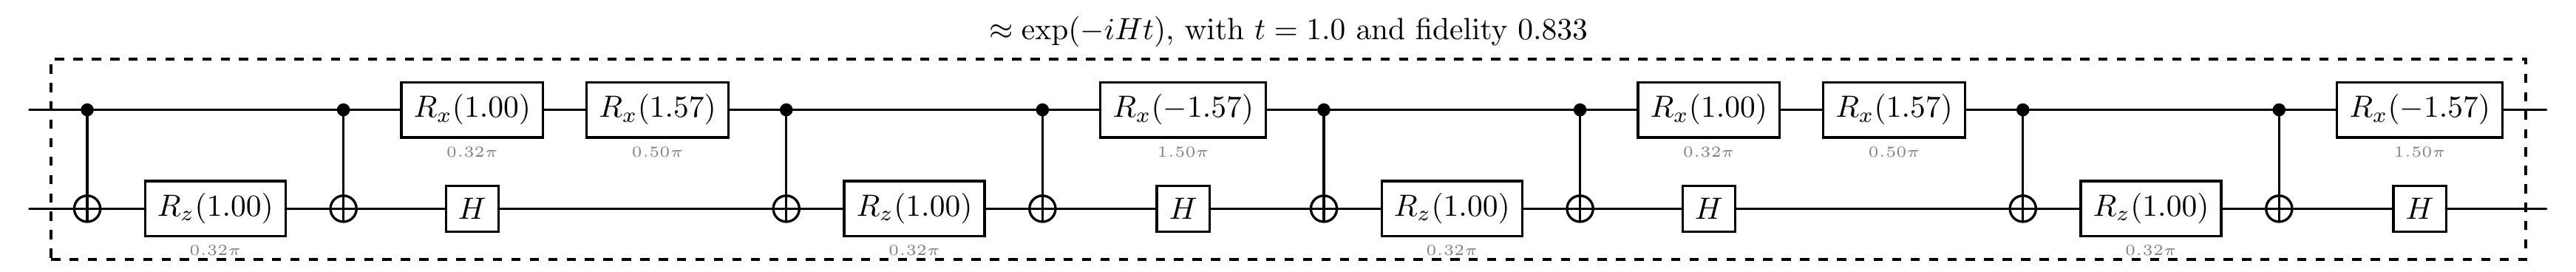

In [4]:
t = 1

cir = Circuit(2)
cir.trotter(h, t, num_steps=2, order=1)
print(f'The circuit with the Trotter layer with number of steps=2 and order=1')
cir.plot('detailed')

We can also determine which qubits in the circuit are used to simulate the corresponding Hamiltonian by specifying the qubit indices.

The repeated section slices in a Trotter circuit.


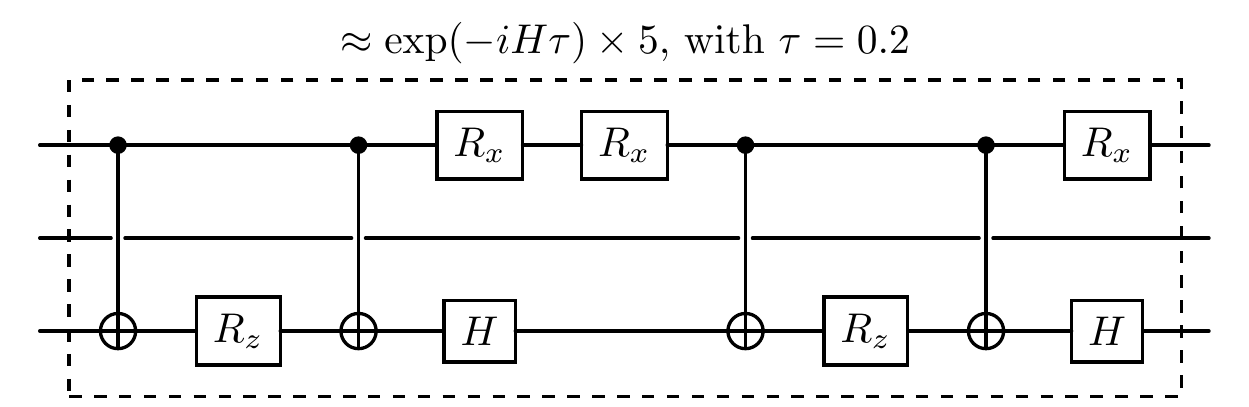

In [5]:
cir = Circuit(3)
cir.trotter(h, t, num_steps=5, qubits_idx=[0, 2])
print(f'The repeated section slices in a Trotter circuit.')
cir.plot('compact')

### Verification of Trotter decomposition

For a real physical system, we often need to calculate the real error in order to determine the circuit depth needed to simulate the system. It can be shown that the error bound on the error for the 2k-th order product formula [29] is：

$$\epsilon \left( e^{-iHt}, \left(S_{1}(\tau)\right)^r \right) \leq \frac{(tn\Lambda)^2}{r} \exp\left(\frac{|t|n\Lambda}{r}\right)  \tag{14}$$

$$\epsilon \left( e^{-iHt}, \left(S_{2k}(\tau)\right)^r \right) \leq \frac{\left(2n5^{k-1}\Lambda|t|\right)^{2k+1}}{3r^{2k}} \exp\left(\frac{2n5^{k-1}\Lambda|t|}{r}\right), \quad k \geq 1.  \tag{15}$$

with $\Lambda = \max_i ||H_i||_F$ is the maximum of Frobenius norm of $H_i$. Still consider the same hamiltonian in (13), we can calculate the real error of the circuit as follows:

To quantify how well our Trotter decomposition approximates the ideal time evolution, we compute the fidelity between the exact evolution operator $e^{-iHt}$ and the Trotter-approximated circuit. The gate fidelity is defined as $F(U_1, U_2) = |\text{Tr}(U_1^\dagger U_2)|^2/d^2$, where $d$ is the dimension of the Hilbert space. It measures the similarity between two unitary operations, with $F = 1$ indicating perfect agreement and $F = 0$ meaning the operations are completely orthogonal.

In [6]:
ideal_gate = torch.linalg.matrix_exp(-1j * t * h.matrix)

num_steps = 2
order = 2

cir = Circuit(2)
cir.trotter(h, t, num_steps=num_steps, order=order)

trotter_gate = cir.matrix
fidelity = gate_fidelity(ideal_gate, trotter_gate).item()

print('The fidelity of the circuit is', fidelity)

The fidelity of the circuit is 0.9935372665966202


The error could be further reduced if we further split the evolution process into more 'pieces':

The gate fidelity of Trotter circuit with different number of Trotter steps:


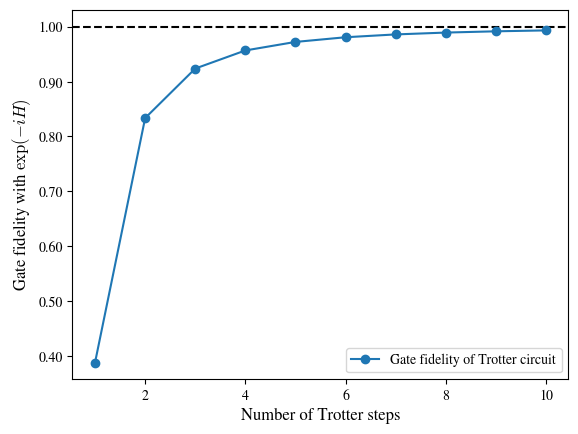

In [7]:
def get_fidelity(n_steps: int) -> float:
    r"""Compute the gate fidelity of the Trotter circuit with n_steps steps.
    
    Args:
        n_steps: Number of Trotter steps.
        
    Returns:
        Gate fidelity of the Trotter circuit.
    """
    cir = Circuit(2)
    cir.trotter(h, 1, num_steps=n_steps)
    return gate_fidelity(cir.matrix, ideal_gate).item()

print('The gate fidelity of Trotter circuit with different number of Trotter steps:')
plt.axhline(1, ls='--', color='black')
plt.plot(np.arange(1, 11), [get_fidelity(r) for r in np.arange(1, 11)], 'o-', label='Gate fidelity of Trotter circuit')
plt.xlabel('Number of Trotter steps', fontsize=12)
plt.ylabel('Gate fidelity with ' + r'$\exp(-iH)$', fontsize=12)


plt.ticklabel_format(style='plain', axis='y')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))

plt.legend()
plt.show()

<a id="conclusion"></a>

## Conclusion

This tutorial has presented a comprehensive treatment of Hamiltonian simulation using Trotter-Suzuki decomposition methods. We have covered the theoretical foundations starting from the Schrödinger equation, analyzed the structure and error bounds of various order Trotter formulas, and demonstrated practical implementation using the QuAIRKit framework.

The key insights from our analysis include:
- Trotter decomposition provides a systematic approach to approximate time evolution on quantum computers, with controllable error that decreases with the number of time slices.
- Higher-order Suzuki formulas offer improved accuracy at the cost of increased circuit depth, requiring careful optimization based on hardware constraints.
- Numerical verification through gate fidelity calculations provides practical guidance for parameter selection, often yielding better performance than theoretical worst-case bounds suggest.

While Trotter methods remain the workhorse of current quantum simulation implementations, emerging techniques such as quantum signal processing and qubitization promise improved asymptotic performance. As quantum hardware continues to advance, the ability to simulate increasingly complex Hamiltonians will unlock applications across chemistry, materials science, and fundamental physics, fulfilling the original vision of quantum computation as a tool for understanding quantum systems.

## References


[1] Feynman, Richard P. "Simulating physics with computers." Feynman and computation. cRc Press, 2018. 133-153.

[2] Lloyd, Seth. "Universal quantum simulators." Science 273.5278 (1996): 1073-1078.

[3] Cao, Yudong, et al. "Quantum chemistry in the age of quantum computing." Chemical reviews 119.19 (2019): 10856-10915.

[4] Georgescu, Iulia M., Sahel Ashhab, and Franco Nori. "Quantum simulation." Reviews of Modern Physics 86.1 (2014): 153-185.

[5] Banuls, Mari Carmen, et al. "Simulating lattice gauge theories within quantum technologies." The European physical journal D 74.8 (2020): 165.

[6] Childs, Andrew M., et al. "Toward the first quantum simulation with quantum speedup." Proceedings of the National Academy of Sciences 115.38 (2018): 9456-9461.

[7] Suzuki, Masuo. "General theory of fractal path integrals with applications to many‐body theories and statistical physics." Journal of mathematical physics 32.2 (1991): 400-407.

[8] Berry, Dominic W., et al. "Simulating Hamiltonian dynamics with a truncated Taylor series." Physical review letters 114.9 (2015): 090502.

[9] Childs, Andrew M., and Nathan Wiebe. "Hamiltonian simulation using linear combinations of unitary operations." arXiv preprint arXiv:1202.5822 (2012).

[10] Low, Guang Hao, and Isaac L. Chuang. "Hamiltonian simulation by qubitization." Quantum 3 (2019): 163.

[11] Yuan, Xiao, et al. "Theory of variational quantum simulation." Quantum 3 (2019): 191.

[12] Sakurai, Jun John, and Jim Napolitano. Modern quantum mechanics. Cambridge University Press, 2020.

[13] Whitfield, James D., Jacob Biamonte, and Alán Aspuru-Guzik. "Simulation of electronic structure Hamiltonians using quantum computers." Molecular Physics 109.5 (2011): 735-750.

[14] Nielsen, Michael A., and Isaac L. Chuang. Quantum computation and quantum information. Cambridge university press, 2010.

[15] Magnus, Wilhelm. "On the exponential solution of differential equations for a linear operator." Communications on pure and applied mathematics 7.4 (1954): 649-673.

[16] Cohen-Tannoudji, Claude, Bernard Diu, and Franck Laloë. Quantum mechanics, volume 3: fermions, bosons, photons, correlations, and entanglement. John Wiley & Sons, 2019.

[17] Kitaev, A. Yu. "Quantum measurements and the Abelian stabilizer problem." arXiv preprint quant-ph/9511026 (1995).

[18] Häner, Thomas, and Damian S. Steiger. "5 petabyte simulation of a 45-qubit quantum circuit." Proceedings of the International Conference for High Performance Computing, Networking, Storage and Analysis. 2017.

[19] Abrams, Daniel S., and Seth Lloyd. "Quantum algorithm providing exponential speed increase for finding eigenvalues and eigenvectors." Physical Review Letters 83.24 (1999): 5162.

[20] O’Brien, Thomas E., et al. "Calculating energy derivatives for quantum chemistry on a quantum computer." npj Quantum Information 5.1 (2019): 113.

[21] Albash, Tameem, and Daniel A. Lidar. "Adiabatic quantum computation." Reviews of Modern Physics 90.1 (2018): 015002.

[22] Raeisi, Sadegh, Nathan Wiebe, and Barry C. Sanders. "Quantum-circuit design for efficient simulations of many-body quantum dynamics." New Journal of Physics 14.10 (2012): 103017.

[23] Low, Guang Hao, and Isaac L. Chuang. "Optimal Hamiltonian simulation by quantum signal processing." Physical review letters 118.1 (2017): 010501.

[24] Berry, Dominic W., et al. "Exponential improvement in precision for simulating sparse Hamiltonians." Proceedings of the forty-sixth annual ACM symposium on Theory of computing. 2014.

[25] Kliesch, Martin, and Ingo Roth. "Theory of quantum system certification." PRX quantum 2.1 (2021): 010201.

[26] Trotter, Hale F. "On the product of semi-groups of operators." Proceedings of the American Mathematical Society 10.4 (1959): 545-551.

[27] Childs, Andrew M., and Yuan Su. "Nearly optimal lattice simulation by product formulas." Physical review letters 123.5 (2019): 050503.

*Table: Notation conventions used in this tutorial*

| Symbol | Variant | Description |
|:------:|:-------:|:------------|
| $H$ | $H_i$ | Hamiltonian (term) |
| $n$ |  | Total number of Hamiltonian terms |
| $X, Y, Z$ |  | Pauli operators |
| $r$ |  | Number of Trotter steps |
| $t$ | $\tau$ | Evolution time (total or per step) |
| $S_k(\tau)$ |  | $k$-th order Trotter-Suzuki decomposition |
| $\|\|\cdot\|\|_F$ |  | Frobenius norm |
| $\Lambda$ |  | Maximum of $\|\|H_i\|\|_F$ |
| $\epsilon$ |  | Approximation error |
| $U(t)$ |  | Time evolution operator |

In [8]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.4
torch: 2.8.0+cpu
numpy: 2.2.6
scipy: 1.15.3
matplotlib: 3.10.6
---------SYSTEM---------
Python version: 3.10.18
OS: Windows
OS version: 10.0.26100
---------DEVICE---------
CPU: ARMv8 (64-bit) Family 8 Model 1 Revision 201, Qualcomm Technologies Inc
